# Redes Neurais - Previsão de Série Temporal: Valor do Bitcoin

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data_bitcoin.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2176 entries, 0 to 2175
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              2176 non-null   object 
 1   open              2176 non-null   float64
 2   high              2176 non-null   float64
 3   low               2176 non-null   float64
 4   close             2176 non-null   float64
 5   number_of_trades  2176 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 102.1+ KB


In [4]:
df.describe()

,open,high,low,close,number_of_trades
count,2176.000000,2176.000000,2176.000000,2176.000000,2.176000e+03
mean,20074.277578,20613.574283,19468.753051,20085.572486,1.462627e+06
std,16058.230026,16490.568746,15560.344106,16055.913598,2.057254e+06
min,3188.010000,3276.500000,2817.000000,3189.020000,2.153000e+03
25%,7627.735000,7829.747500,7424.250000,7628.355000,2.803172e+05
50%,11705.580000,11933.360000,11334.110000,11728.035000,7.407820e+05
75%,29866.525000,30423.460000,29224.382500,29866.532500,1.595982e+06
max,67525.820000,69000.000000,66222.400000,67525.830000,1.522359e+07


In [5]:
df_close = df['close']

In [6]:
df_close.head()

0    4285.08
1    4108.37
2    4139.98
3    4086.29
4    4016.00
Name: close, dtype: float64

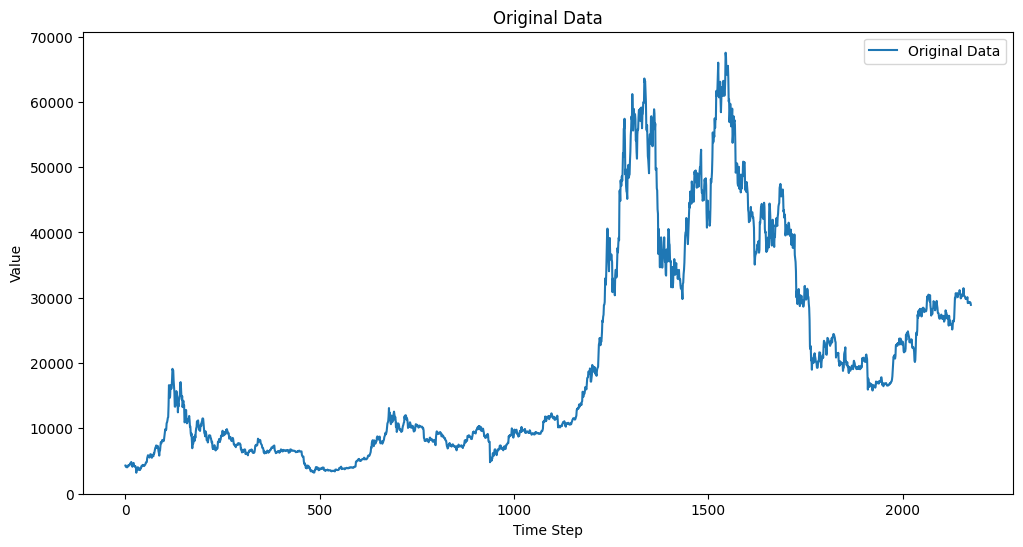

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df_close.values, label='Original Data')
plt.title('Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

## Abordagem 1: Apenas os valores de fechamento

In [8]:
X = torch.tensor(df_close.values)

size = len(X)
size_test = int(size * 0.2)  # transforma em inteiro

X_train = X[:-size_test]  # tudo, menos os últimos 20%
X_test = X[-size_test:]   # os últimos 20%

print(X_train.shape)
print(X_test.shape)

torch.Size([1741])
torch.Size([435])


In [9]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [10]:
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return torch.stack(xs), torch.stack(ys)

In [11]:
X_raw = df_close.values.reshape(-1, 1)  # <- torna 2D: [N, 1]

scaler = MinMaxScaler(feature_range=(0, 1))

# Ajusta e transforma
X_scaled_np = scaler.fit_transform(X_raw)  # shape [N, 1]\

# Converte para tensor
X_scaled = torch.tensor(X_scaled_np, dtype=torch.float32)

In [12]:
# Hiperparâmetros

seq_length = 10
num_epochs = 100

In [13]:
train_size = int(len(X_scaled) * 0.8)
X_train_raw = X_scaled[:train_size]
X_test_raw = X_scaled[train_size:]

trainX, trainY = create_sequences(X_train_raw, seq_length)
testX, testY = create_sequences(X_test_raw, seq_length)

In [14]:
model = LSTMModel(input_dim=1, hidden_dim=100, layer_dim=1, output_dim=1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [15]:
h0, c0 = None, None

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    outputs, h0, c0 = model(trainX, h0, c0)

    loss = criterion(outputs, trainY)
    loss.backward()
    optimizer.step()

    h0 = h0.detach()
    c0 = c0.detach()

    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [10/100], Loss: 0.0707
Epoch [20/100], Loss: 0.0183
Epoch [30/100], Loss: 0.0048
Epoch [40/100], Loss: 0.0020
Epoch [50/100], Loss: 0.0005
Epoch [60/100], Loss: 0.0005
Epoch [70/100], Loss: 0.0004
Epoch [80/100], Loss: 0.0004
Epoch [90/100], Loss: 0.0004
Epoch [100/100], Loss: 0.0004


real_part: (1741,), forecast_part: (426,), combined: (2167,)


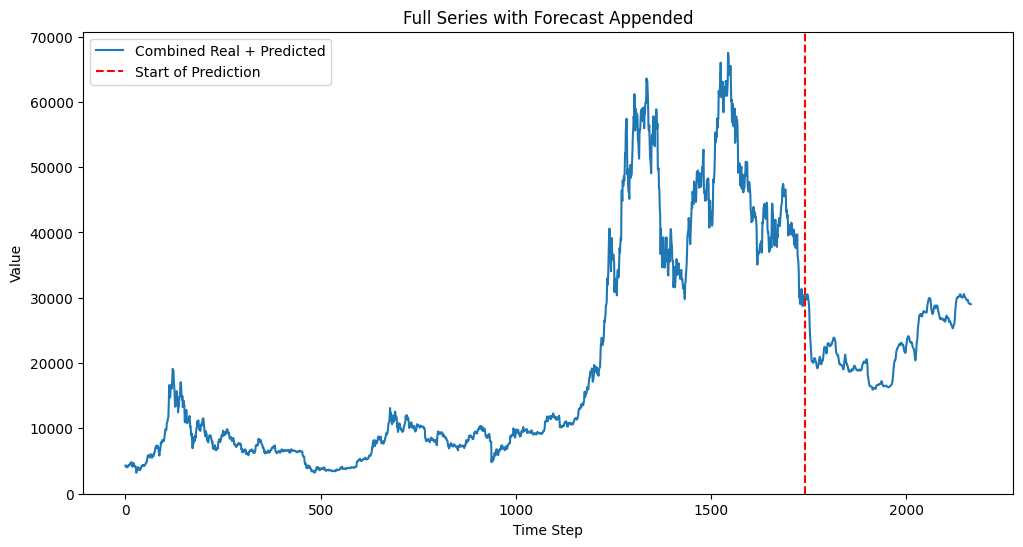

In [18]:
# Pega parte real antes do teste
look_back = testX.shape[1]  # seu seq_length
train_end_idx = len(X_raw) - len(testX) - look_back + 1

# Parte real até a entrada do teste
real_part = X_raw[:train_end_idx].squeeze()

forecast_part = y_pred_denorm.squeeze()

# Cria vetor final
combined = np.concatenate((real_part, forecast_part))

time_steps = np.arange(len(combined))

print(f"real_part: {real_part.shape}, forecast_part: {forecast_part.shape}, combined: {combined.shape}")

plt.figure(figsize=(12, 6))
plt.plot(time_steps, combined, label='Combined Real + Predicted', linestyle='-')
plt.axvline(x=len(real_part)-1, color='r', linestyle='--', label='Start of Prediction')
plt.title('Full Series with Forecast Appended')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()

(426,) (426, 1) (426, 1)


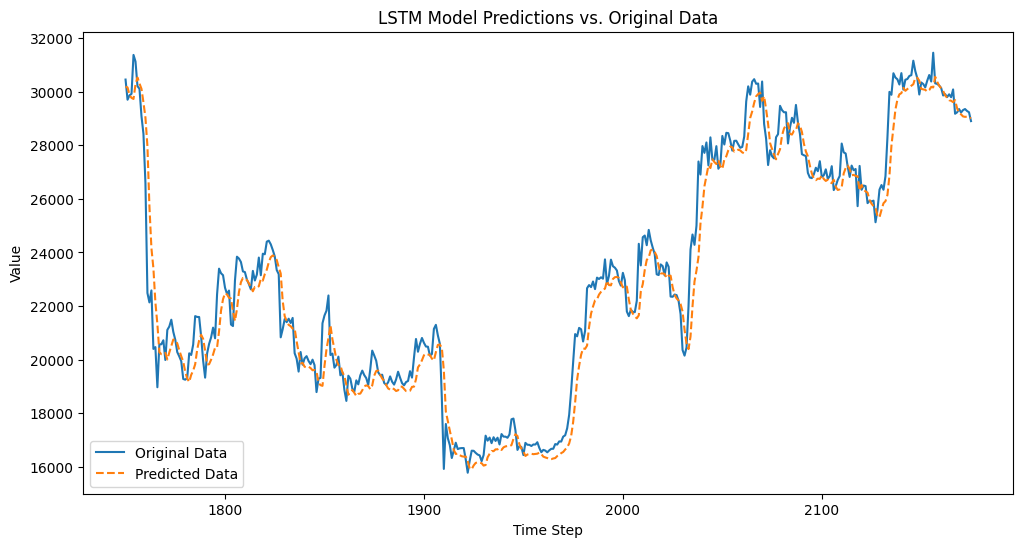

In [16]:
model.eval()
with torch.no_grad():
    y_pred_test, _, _ = model(testX)

y_pred_np = y_pred_test.cpu().numpy()
y_pred_denorm = scaler.inverse_transform(y_pred_np.reshape(-1, 1))

original = X_raw[-len(y_pred_denorm):]
time_steps = np.arange(len(X_raw) - len(y_pred_denorm), len(X_raw))

print(time_steps.shape, original.shape, y_pred_denorm.shape)

plt.figure(figsize=(12, 6))
plt.plot(time_steps, original, label='Original Data')
plt.plot(time_steps, y_pred_denorm.squeeze(), label='Predicted Data', linestyle='--')
plt.title('LSTM Model Predictions vs. Original Data')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.show()
